In [63]:
library(dplyr)
library(caret)
library(ggplot2)
library(viridis)
library(tidyverse)
library(h2o)
library(gt)

In [ ]:
h2o.shutdown(prompt=FALSE)


In [66]:
h2o.init()


H2O is not running yet, starting it now...


Warning message in .h2o.startJar(ip = ip, port = port, name = name, nthreads = nthreads, :
"You have a 32-bit version of Java. H2O works best with 64-bit Java.
Please download the latest Java SE JDK from the following URL:
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html#java-requirements"



Note:  In case of errors look at the following log files:
    C:\Users\willk\AppData\Local\Temp\RtmpM5B3Qf\fileb283e8e4b9d/h2o_willk_started_from_r.out
    C:\Users\willk\AppData\Local\Temp\RtmpM5B3Qf\fileb28505a95/h2o_willk_started_from_r.err


Starting H2O JVM and connecting:  Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         4 seconds 735 milliseconds 
    H2O cluster timezone:       America/New_York 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.44.0.3 
    H2O cluster version age:    1 year, 11 months and 23 days 
    H2O cluster name:           H2O_started_from_R_willk_cvf975 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   0.96 GB 
    H2O cluster total cores:    16 
    H2O cluster allowed cores:  16 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 

Warning message in h2o.clusterInfo():
"
Your H2O cluster version is (1 year, 11 months and 23 days) old. There may be a newer version available.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html"


In [128]:
df <- read.csv("full_clean_data.csv")
df <- df %>% 
  group_by(game_id, play_id) %>% 
  mutate(final_frame = ifelse(max(frame_id) == frame_id, 1, 0))

In [129]:
df_filtered <- df %>%
  drop_na(dist_to_ball_land, speed, accel, direction, accel_direction, optimal_angle, angle_diff)

df_filtered <- df_filtered %>%
  group_by(game_id, play_id, nfl_id) %>%
  mutate(reached_ball = ifelse(dist_to_ball_land < 1.5, 1, 0)) %>% 
  mutate(reached_ball = ifelse(any(final_frame == 1 & reached_ball == 1), 1, 0)) %>%
  ungroup()

In [130]:
model <- h2o.loadModel(file.path("h2o_models", "model_with_id_dl2"))

In [93]:
model <- h2o.deeplearning(
  x = features,
  y = target,
  training_frame = train_h2o,
  hidden = c(64, 32),
  epochs = 30,
  activation = "Rectifier",
  categorical_encoding = "OneHotInternal",
  stopping_metric = "AUC",
  seed = 123
)

  |======================================================================| 100%


In [ ]:


model <- h2o.gbm(
  x = features,
  y = target,
  training_frame = train_h2o,
  seed = 123
)

  |===============                                                       |  21%

: 

In [131]:
df_model <- df_filtered %>%
  mutate(
    nfl_id = as.factor(nfl_id),
    reached_ball = as.factor(reached_ball)
  ) %>%
  select(dist_to_ball_land, speed, accel, angle_diff, time_left_s, nfl_id, reached_ball)


set.seed(123)
train_idx <- sample(1:nrow(df_model), 0.8 * nrow(df_model))
train <- df_model[train_idx, ]
test  <- df_model[-train_idx, ]


train_h2o <- as.h2o(train)
test_h2o  <- as.h2o(test)


features <- c("dist_to_ball_land", "speed", "accel", "angle_diff", "time_left_s", "nfl_id")
target   <- "reached_ball"




perf <- h2o.performance(model, newdata = test_h2o)
h2o.auc(perf)
h2o.confusionMatrix(perf)


pred <- h2o.predict(model, test_h2o)
pred_probs <- as.vector(pred$p1)
pred_class <- as.vector(pred$predict)




  |======================================================================| 100%
  |======================================================================| 100%


[1] 0.9958694

,0,1,Error,Rate
,<dbl>,<dbl>,<dbl>,<chr>
0,84934,1960,0.02255622,=1960/86894
1,1264,24430,0.04919436,=1264/25694
Totals,86198,26390,0.02863538,=3224/112588


  |======================================================================| 100%


In [106]:
h2o.saveModel(model, path = "h2o_models", force = TRUE, filename = "model_with_id_dl2")

[1] "C:\\Users\\willk\\Documents\\GitHub\\BigDataBowl2025\\h2o_models\\model_with_id_dl2"

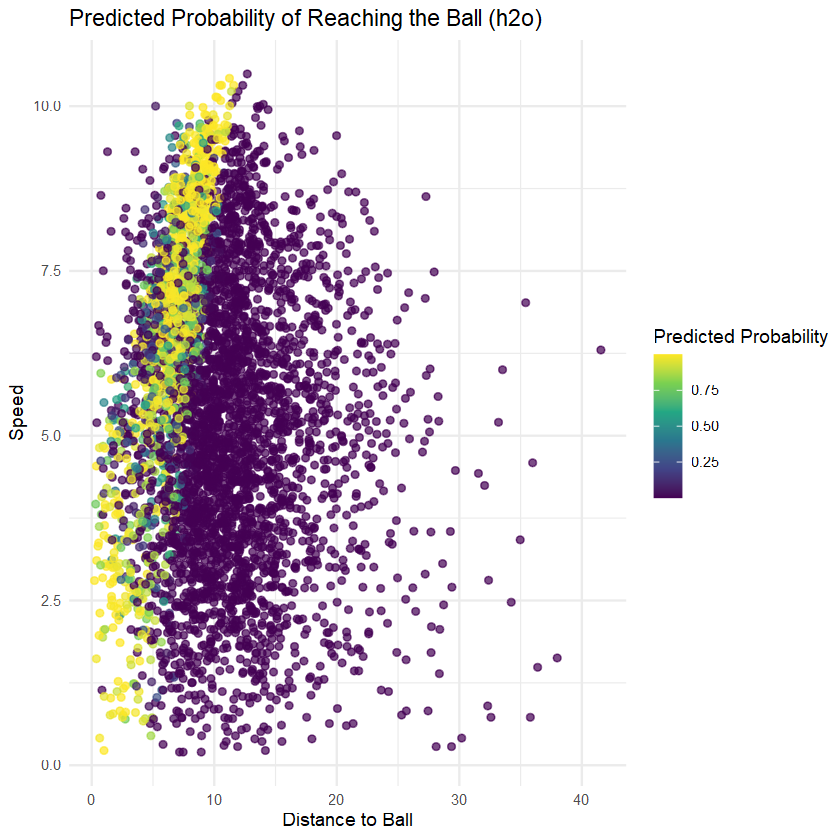

In [132]:
plot_df <- as.data.frame(test_h2o) %>%
  mutate(pred_prob = pred_probs)

ggplot(plot_df |> filter(time_left_s == 1), aes(x = dist_to_ball_land, y = speed, color = pred_prob)) +
  geom_point(alpha = 0.7) +
  scale_color_viridis_c() +
  labs(
    title = "Predicted Probability of Reaching the Ball (h2o)",
    x = "Distance to Ball",
    y = "Speed",
    color = "Predicted Probability"
  ) +
  theme_minimal()

In [79]:
model_no_id <- h2o.deeplearning(
  x = c("dist_to_ball_land", "speed", "accel", "angle_diff", "time_left_s"),
  y = target,
  training_frame = train_h2o,
  hidden = c(64, 32),
  epochs = 30,
  activation = "Rectifier",
  stopping_metric = "AUC",
  seed = 123
)

  |======================================================================| 100%


In [8]:
model_no_id <- h2o.gbm(
  x = c("dist_to_ball_land", "speed", "accel", "angle_diff", "time_left_s"),
  y = target,
  training_frame = train_h2o,
  seed = 123
)

  |======================================================================| 100%


In [80]:
h2o.saveModel(model_no_id, path = "h2o_models", force = TRUE, filename = "model_no_id_dl")

[1] "C:\\Users\\willk\\Documents\\GitHub\\BigDataBowl2025\\h2o_models\\model_no_id_dl"

In [133]:
model_no_id <- h2o.loadModel(file.path("h2o_models", "model_no_id_dl"))

In [134]:
perf2 <- h2o.performance(model_no_id, newdata = test_h2o)
h2o.auc(perf2)
h2o.confusionMatrix(perf2)


pred2 <- h2o.predict(model_no_id, test_h2o)
pred_probs2 <- as.vector(pred2$p1)
pred_class2 <- as.vector(pred2$predict)

plot_df <- plot_df %>% 
  mutate(prob2 = pred_probs2) %>% 
  mutate(effect = pred_prob - prob2)
  

[1] 0.9915298

,0,1,Error,Rate
,<dbl>,<dbl>,<dbl>,<chr>
0,83717,3177,0.03656179,=3177/86894
1,1796,23898,0.06989959,=1796/25694
Totals,85513,27075,0.04416989,=4973/112588


  |======================================================================| 100%


In [135]:
library(nflreadr)
players <- load_players()

In [136]:
plot_df <- plot_df %>% 
  left_join(players %>% 
              select(nfl_id, display_name, pff_position), by = c("nfl_id"))


In [138]:
plot_df %>% 
  group_by(nfl_id) %>%
  summarise(name = unique(display_name), 
            n = n(), 
            avg = round(mean(effect), 5), 
            total = round(sum(effect), 5), 
            pos = unique(pff_position)) %>% 
  filter(n > 50) %>% 
  arrange(desc(avg)) %>%
  head()

nfl_id,name,n,avg,total,pos
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
44978,Jamal Agnew,55,0.09041,4.97265,WR
54694,Bo Melton,64,0.09004,5.76252,WR
52897,Grayland Arnold,56,0.06670,3.73532,CB
53511,Dyami Brown,59,0.06383,3.76581,WR
52433,Brandon Aiyuk,267,0.05713,15.25296,WR
47879,Dawson Knox,56,0.05547,3.10633,TE


In [139]:
varimp <- h2o.varimp(model)
varimp

variable,relative_importance,scaled_importance,percentage
<chr>,<dbl>,<dbl>,<dbl>
dist_to_ball_land,1.0000000,1.0000000,0.010290816
time_left_s,0.7295391,0.7295391,0.007507553
angle_diff,0.4751901,0.4751901,0.004890094
speed,0.3715938,0.3715938,0.003824004
nfl_id.54475,0.2471749,0.2471749,0.002543632
nfl_id.45004,0.2047185,0.2047185,0.002106721
nfl_id.54476,0.1879578,0.1879578,0.001934239
nfl_id.55133,0.1796632,0.1796632,0.001848881
nfl_id.55885,0.1786138,0.1786138,0.001838082


In [140]:
perf3 <- h2o.performance(model, newdata = as.h2o(df_filtered))
h2o.auc(perf3)
h2o.confusionMatrix(perf3)


pred3 <- h2o.predict(model, as.h2o(df_filtered))
pred_probs3 <- as.vector(pred3$p1)
pred_class3 <- as.vector(pred3$predict)

  |======================================================================| 100%


[1] 0.9970763

,0,1,Error,Rate
,<dbl>,<dbl>,<dbl>,<chr>
0,425568,7918,0.01826587,=7918/433486
1,5628,123822,0.04347625,=5628/129450
Totals,431196,131740,0.02406313,=13546/562936


  |======================================================================| 100%
  |======================================================================| 100%


In [141]:
perf4 <- h2o.performance(model_no_id, newdata = as.h2o(df_filtered))
h2o.auc(perf4)
h2o.confusionMatrix(perf4)


pred4 <- h2o.predict(model_no_id, as.h2o(df_filtered))
pred_probs4 <- as.vector(pred4$p1)
pred_class4 <- as.vector(pred4$predict)


  |======================================================================| 100%


[1] 0.9913953

,0,1,Error,Rate
,<dbl>,<dbl>,<dbl>,<chr>
0,417135,16351,0.03771979,=16351/433486
1,8760,120690,0.06767092,=8760/129450
Totals,425895,137041,0.04460720,=25111/562936


  |======================================================================| 100%
  |======================================================================| 100%


In [142]:
pred5 <- h2o.predict(model, as.h2o(df_filtered %>% select(-nfl_id)))
pred_probs5 <- as.vector(pred5$p1)
pred_class5 <- as.vector(pred5$predict)

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in doTryCatch(return(expr), name, parentenv, handler):
"Test/Validation dataset is missing column 'nfl_id': substituting in a column of NaN"


In [143]:
data <- df_filtered %>% 
  mutate(pred1 = pred_probs3, pred2 = pred_probs5, effect = pred1 - pred2) %>% 
  left_join(players %>% mutate(nfl_id = as.numeric(nfl_id)) %>% select(nfl_id, display_name, pff_position), by = c("nfl_id"))


In [144]:
data %>% 
  group_by(nfl_id) %>%
  summarise(name = unique(display_name), 
            n = n(), 
            avg = round(mean(effect), 5), 
            total = round(sum(effect), 5), 
            pos = unique(pff_position)) %>% 
  #filter(n > 50, pos != "WR", pos != "TE", pos != "HB") %>% 
  filter(n > 50, pos == "CB") %>% 
  arrange(desc(total)) %>%
  head(10)

nfl_id,name,n,avg,total,pos
<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>
42441,Steven Nelson,1742,0.02270,39.54767,CB
56353,Starling Thomas V,701,0.05595,39.21825,CB
53601,Deommodore Lenoir,1671,0.02317,38.72344,CB
43986,Antonio Hamilton,877,0.03914,34.32560,CB
48241,Keisean Nixon,1585,0.01683,26.67043,CB
55881,Christian Gonzalez,449,0.05729,25.72341,CB
54525,Cam Taylor-Britt,1425,0.01743,24.83774,CB
56097,Carrington Valentine,1151,0.01712,19.70205,CB
37078,Patrick Peterson,1802,0.01059,19.09048,CB


In [155]:
data %>% 
  group_by(nfl_id) %>%
  summarise(name = unique(display_name), 
            n = n(), 
            avg = round(mean(effect), 5), 
            total = round(sum(effect), 5), 
            pos = unique(pff_position)) %>% 
  #filter(n > 50, pos != "WR", pos != "TE", pos != "HB") %>% 
  filter(n > 50, pos == "WR") %>% 
  arrange((total)) %>%
  head(10)

nfl_id,name,n,avg,total,pos
<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>
52536,Gabe Davis,908,-0.14517,-131.81204,WR
41233,Mike Evans,1612,-0.06556,-105.68837,WR
40488,Adam Thielen,1369,-0.06423,-87.92541,WR
54476,Chris Olave,1730,-0.04648,-80.40453,WR
54508,Wan'Dale Robinson,612,-0.12423,-76.02921,WR
52442,Michael Pittman,1283,-0.05850,-75.05093,WR
47808,Marquise Brown,1062,-0.06542,-69.47736,WR
55939,Cedric Tillman,477,-0.11765,-56.11882,WR
55938,Jalin Hyatt,613,-0.08889,-54.49241,WR


In [152]:
data %>% 
  group_by(nfl_id) %>%
  summarise(name = unique(display_name), 
            n = n(), 
            avg = round(mean(effect), 5), 
            total = round(sum(effect), 5), 
            pos = unique(pff_position)) %>% 
  #filter(n > 50, pos != "WR", pos != "TE", pos != "HB") %>% 
  filter(n > 50, pos == "S") %>% 
  arrange(desc(total)) %>%
  head(10)

nfl_id,name,n,avg,total,pos
<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>
52607,Jordan Fuller,2051,0.01521,31.19795,S
54808,Reed Blankenship,1724,0.01567,27.01950,S
46137,Justin Reid,1506,0.01786,26.90418,S
47899,Amani Hooker,1521,0.01382,21.01607,S
55910,Brian Branch,1683,0.01134,19.07966,S
55931,Sydney Brown,643,0.02666,17.14098,S
45004,Xavier Woods,1128,0.01238,13.96424,S
43351,James Bradberry,2175,0.00629,13.68652,S
54479,Kyle Hamilton,1558,0.00852,13.27760,S


In [147]:
top10_by_pos <- function(df, position) {
  df = df %>%
    group_by(nfl_id) %>%
    filter(n() > 500) %>%
    summarise(
      name  = unique(display_name),
      n     = n(),
      avg   = mean(effect),
      total = round(sum(effect), 5),
      pos   = unique(pff_position),
      .groups = "drop"
    ) %>%
    filter(n > 50, pos == position) %>%
    arrange(desc(avg)) %>%
    slice_head(n = 10)

  gt_table <- df %>%
    arrange(pos, desc(avg)) %>%
    select(pos, name, avg) %>%
    mutate(avg = paste0(round(avg * 100, 2), "%")) %>%
    gt() %>%
      cols_label(
        name = "Name",
        avg  = "Average Effect"
      ) %>%
      fmt_number(columns = avg, decimals = 5) 

  gtsave(
    gt_table,
      filename = paste0(position, "_table.png"),
      vwidth = 1200,
      vheight = 2000
    )
  }

top10_by_pos(data, "CB")
top10_by_pos(data, "WR")
top10_by_pos(data, "S")
top10_by_pos(data, "TE")


In [148]:
bot10_by_pos <- function(df, position) {
  df = df %>%
    group_by(nfl_id) %>%
    filter(n() > 500) %>%
    summarise(
      name  = unique(display_name),
      n     = n(),
      avg   = mean(effect),
      total = round(sum(effect), 5),
      pos   = unique(pff_position),
      .groups = "drop"
    ) %>%
    filter(n > 50, pos == position) %>%
    arrange((avg)) %>%
    slice_head(n = 10)

  gt_table <- df %>%
    arrange(pos, (avg)) %>%
    select(pos, name, avg) %>%
    mutate(avg = paste0(round(avg * 100, 2), "%")) %>%
    gt() %>%
      cols_label(
        name = "Name",
        avg  = "Average Effect"
      ) %>%
      fmt_number(columns = avg, decimals = 5) 

  gtsave(
    gt_table,
      filename = paste0(position, "_table_bottom.png"),
      vwidth = 1200,
      vheight = 2000
    )
  }

bot10_by_pos(data, "CB")
bot10_by_pos(data, "WR")
bot10_by_pos(data, "S")
bot10_by_pos(data, "TE")

In [ ]:
test_df <- expand.grid(
  nfl_id = 52536, # 54508 for wandale robinson, 44881 for cooper kupp, 53434 jamarr chase, 55931 s brown, 56353 thomas V, 
                  # 52433 aiyuk, 43324 henry, 52536 davis
  dist_to_ball_land = seq(1, 30),
  time_left_s = 2,
  angle_diff = seq(0, 180, 5),
  speed = 15, 
  accel = 0
)

test_pred <- h2o.predict(model, as.h2o(test_df))
test_probs <- as.vector(test_pred$p1)

test_df <- test_df %>% 
  mutate(pred = test_probs)

# Mirror your 0–180° data to make a full 0–360° field
test_df_mirrored <- test_df %>%
  mutate(angle_diff_mirror = angle_diff) %>%
  bind_rows(
    test_df %>%
      mutate(angle_diff_mirror = 360 - angle_diff)
  ) %>% 
  mutate(reach = pred > .5)

# Plot: 0° straight up, increasing clockwise
ggplot(test_df_mirrored, aes(x = angle_diff_mirror, y = dist_to_ball_land, fill = pred)) +
  geom_tile() +
  coord_polar(start = 0, direction = 1) +  # ✅ This combination puts 0° at top and increases clockwise
  scale_fill_viridis_c(option = "mako", name = "Reach Prob.") +
  scale_x_continuous(
    breaks = seq(0, 330, 30),
    labels = paste0(seq(0, 330, 30), "°")
  ) +
  scale_y_continuous(
    limits = c(0,30),
    breaks = seq(0, 30, 10),
    name = "Distance to Ball Landing"
  ) +
  labs(
    title = "Reachable Area Heat Map - Gabe Davis",
    subtitle = paste("2 Seconds Remaining, Speed = 15mph"),
    x = "Angle (°)",
    y = "Distance"
  ) +
  #facet_wrap(~ reorder(time_left_s, -time_left_s)) +
  theme_minimal(base_size = 13) +
  theme(
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(color = "gray80", linetype = "dotted"),
    #plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(size = 10, face = "bold"),
    legend.position = "right"
  ) +
  # Optional: show the player in the center
  annotate("point", x = 0, y = 0, size = .5, color = "white")


  |======================================================================| 100%
  |======================================================================| 100%


  |======================================================================| 100%
  |======================================================================| 100%


Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"
Warning message in min(d[d > tolerance]):
"no non-missing arguments to min; returning Inf"
Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"
Warning message in min(d[d > tolerance]):
"no non-missing arguments to min; returning Inf"
Warning message:
"Removed 1064 rows containing missing values or values outside the scale range
(`geom_tile()`)."


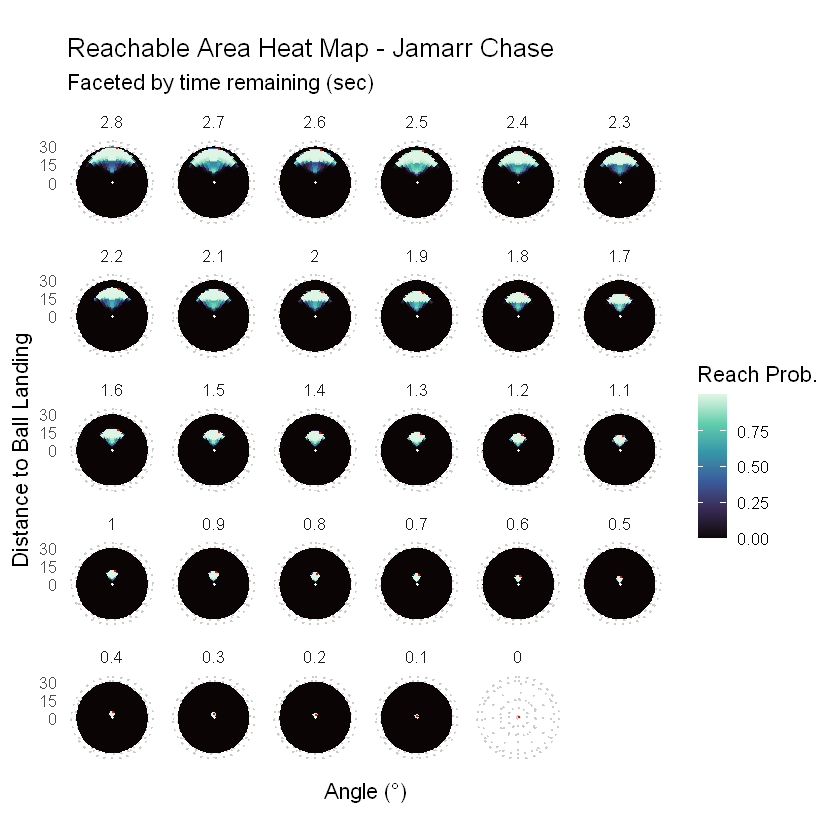

In [10]:
chase <- read.csv("chase.csv") %>%
    filter(player_role == "Targeted Receiver", !is.na(time_left_s)) %>%
    select(nfl_id, dist_to_ball_land, time_left_s, angle_diff, speed, accel)

speeds <- chase %>% 
  pull(speed)

times <- chase %>% 
  pull(time_left_s)

accels <- chase %>% 
  pull(accel)

test_df <- data.frame()
for(i in seq(1, length(times) - 1)) {
  time = times[i]
  speed = speeds[i]
  accel = accels[i]

  temp_df <- expand.grid(
    nfl_id = 53434, # 54508 for wandale robinson, 44881 for cooper kupp, 53434 jamarr chase
    dist_to_ball_land = seq(1, 30),
    time_left_s = time,
    angle_diff = seq(0, 180, 10),
    speed = speed,
    accel = accel
  )

  test_df <- bind_rows(test_df, temp_df)
}

test_pred <- h2o.predict(model, as.h2o(test_df))
test_probs <- as.vector(test_pred$p1)

test_df <- test_df %>% 
  mutate(pred = test_probs)


# Mirror your 0–180° data to make a full 0–360° field
test_df_mirrored <- test_df %>%
  mutate(angle_diff_mirror = angle_diff) %>%
  bind_rows(
    test_df %>%
      mutate(angle_diff_mirror = 360 - angle_diff)
  ) %>% 
  mutate(reach = pred > .5)

ball_df <- chase %>% 
  distinct(time_left_s, dist_to_ball_land, angle_diff)

# Plot: 0° straight up, increasing clockwise
ggplot(test_df_mirrored, aes(x = angle_diff_mirror, y = dist_to_ball_land, fill = pred)) +
  geom_tile() +
  coord_polar(start = 0, direction = 1) +  # ✅ This combination puts 0° at top and increases clockwise
  scale_fill_viridis_c(option = "mako", name = "Reach Prob.") +
  scale_x_continuous(
    breaks = seq(0, 330, 30),
    #labels = paste0(seq(0, 330, 30), "°")
    labels = NULL
  ) +
  scale_y_continuous(
    limits = c(0,30),
    breaks = seq(0, 30, 15),
    name = "Distance to Ball Landing"
  ) +
  labs(
    title = "Reachable Area Heat Map - Jamarr Chase",
    subtitle = paste("Faceted by time remaining (sec)"),
    x = "Angle (°)",
    y = "Distance"
  ) +
  facet_wrap(~ reorder(time_left_s, -time_left_s)) +
  theme_minimal(base_size = 13) +
  theme(
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(color = "gray80", linetype = "dotted"),
    #plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(size = 10, face = "bold"),
    legend.position = "right"
  ) +
  # Optional: show the player in the center
  annotate("point", x = 0, y = 0, size = .5, color = "white") + 
  geom_point(
    data = ball_df,
    aes(x = angle_diff, y = dist_to_ball_land),
    color = "red",
    size = .2,
    inherit.aes = FALSE
  )


In [ ]:
extra_data <- data %>% 
  select(game_id, play_id, frame_id, x, y, 15:28)


In [ ]:
head(extra_data)

game_id,play_id,frame_id,x,y,time_left_s,dist_to_ball_land,speed,direction,accel,accel_direction,optimal_angle,angle_diff,final_frame,reached_ball,pred1,pred2,effect,display_name
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2023090700,101,1,53.20,13.98,2.0,17.40240,7.864477,-11.73857,-0.35522904,-46.33304,-54.68431,42.94574,0,0,2.694742e-03,0.134347065,-0.131652323,Josh Reynolds
2023090700,101,2,53.96,13.78,1.9,16.80744,7.858753,-14.74356,-0.05724015,-104.03624,-56.40448,41.66092,0,0,3.549731e-03,0.070086685,-0.066536954,Josh Reynolds
2023090700,101,3,54.70,13.54,1.8,16.20528,7.779460,-17.96914,-0.79292946,-116.56505,-58.11455,40.14541,0,0,7.563702e-04,0.030466502,-0.029710132,Josh Reynolds
2023090700,101,4,55.41,13.27,1.7,15.60777,7.596052,-20.82089,-1.83408530,-135.00000,-59.80434,38.98345,0,0,1.450470e-05,0.008431210,-0.008416705,Josh Reynolds
2023090700,101,5,56.09,12.95,1.6,14.99526,7.515318,-25.20112,-0.80733915,-120.96376,-61.43529,36.23416,0,0,6.486375e-06,0.004115084,-0.004108597,Josh Reynolds
2023090700,101,6,56.73,12.58,1.5,14.36944,7.392564,-30.03328,-1.22753860,-128.65981,-62.97132,32.93804,0,0,8.299145e-07,0.001325235,-0.001324405,Josh Reynolds
